# CODE 05: Listing 5.3 2D Fourier Method - Pag 120

/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/hom

<IPython.core.display.Javascript object>


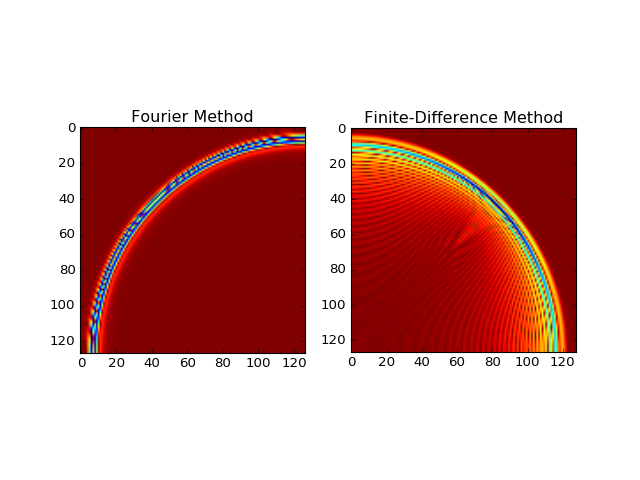

In [1]:

#------------------------------------------------------------------------------
#CHAPTER 5:  The Pseudospectral Method  
#------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from ricker import ricker

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

# Fourier derivative method   
def fourier_derivative_2nd(f, dx):
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: nx/2] = k[: nx/2] * dk 
    k[nx/2 :] = k[: nx/2] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num
    
# Basic parameters
nt = 600     # number of time steps
nx = 256     # number of grid points in x 
nz = nx      # number of grid points in z
c = 343.     # acoustic velocity
eps = .2     # stability limit
isnap = 600  # snapshot frequency
isx = nx/2   # source location
isz = nz/2
f0 = 200.    # Frequency (div by 5)
xmax = 200
iplot = 0

# initialization of pressure fields
ap = np.zeros((nx, nz), dtype=float)
apnew = np.zeros((nx, nz), dtype=float)
apold = np.zeros((nx, nz), dtype=float)
ad2px = np.zeros((nx, nz), dtype=float)
ad2pz = np.zeros((nx, nz), dtype=float) 
 
sp = np.zeros((nx, nz), dtype= float)
spnew = np.zeros((nx, nz), dtype=float)
spold = np.zeros((nx, nz), dtype=float)
sd2px = np.zeros((nx, nz), dtype=float)
sd2pz = np.zeros((nx, nz), dtype=float); 

dx = xmax/(nx-1)  # calculate space increment
x = np.arange(0, nx)*dx # initialize space coordinates
z = np.arange(0, nx)*dx # initialize space coordinates
dt = eps*dx/c # calculate tim step from stability criterion

# source time function
#time = np.linspace(0, nt * dt, num=nt)
t = np.arange(1, nt+1)*dt  # initialize time axis
T0 = 1./f0
tmp = ricker(dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp
lam = c*T0

# spatial source function
sg = np.zeros((nx, nz), dtype= float)
sigma = 1.5*dx
x0 = x[isx-1] 
z0 = z[isz-1] 
for i in range(nx):
    for j in range(nz):
        sg[i,j] = np.exp(-1/sigma**2 * ((x[i]-x0)**2 +(z[j]-z0)**2))
        
sg = sg/np.amax(sg)

#%% CODE 05: Listing 5.3 2D Fourier Method - Pag 120
# Time extrapolation
for it in range(nt):
    # PS 
    # 2nd space derivative
    for j in np.arange(nz):           
        sd2px[:,j] = fourier_derivative_2nd(np.transpose(sp[:,j]), dx) 
    for i in np.arange(nx):           
        sd2pz[i,:] = fourier_derivative_2nd(sp[i,:], dx) 
    # Time Extrapolation
    spnew = 2*sp - spold + c**2 * dt**2 * (sd2px + sd2pz)    
    spnew = spnew + sg*src[it]*dt**2 # Add sources   
    spold, sp = sp, spnew # Time levels
    
    # FD 5pt
    for i in range(2, nz-2):
        ad2px[i,:] = (-1./12*ap[i+2,:] + 4./3*ap[i+1,:] - 5./2*ap[i,:] + 4./3*ap[i-1,:] - 1./12*ap[i-2,:])/dx**2 # Space derivative 
    for i in range(2, nx-2):
        ad2pz[:,i] = (-1./12*ap[:,i+2] + 4./3*ap[:,i+1] - 5./2*ap[:,i] + 4./3*ap[:,i-1] - 1./12*ap[:,i-2])/dx**2 # Space derivative           
    apnew = 2*ap - apold + dt**2 * c**2 * (ad2px + ad2pz) # Extrapolation    
    apnew = apnew + sg*src[it]*dt**2 # Add source    
    apold, ap = ap, apnew # Time levels
     
    # Plot Wave fields
    if np.mod(it+1, isnap) == 0:        
       plt.subplot(1,2,1)
       plt.imshow(-np.abs(sp[1:nx/2,1:nz/2]))
       plt.title(' Fourier Method ')
       
       plt.subplot(1,2,2)
       plt.imshow(-np.abs(np.transpose(ap[nx/2:nx,1:nz/2])))
       plt.title(' Finite-Difference Method ')             
           
#plt.savefig('Fig_5.12.png')
plt.show()